## Analysis and data plotting

## Imports

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import re

In [105]:
immo = pd.read_csv('../data/clean/details_clean.csv')
#immo = pd.read_csv('../../immo-eliza-analysis-the_chaincoders/details_clean.csv')

pd.set_option('display.max_columns', None) # Displays all the columns


C:\Users\lucav\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (88,105,106,118) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cleaning

Here we are:
* changing *numpy not a number* type to *None* type
* removing some rows which either shouldn't be here (annuity properties) or need further implementation in the scraper (group developments)
* removing substrings to clean up columns for type casting
* displaying the first 5 columns of the dataframe

In [106]:
immo = immo.replace(np.nan, None)


# Replace 'Not specified' with None as in this case it serves no purpose. If a consumption is not provided it might as well be absent
immo['Primary energy consumption'] = immo['Primary energy consumption'].replace('Not specified', None)
immo['CO₂ emission'] = immo['CO₂ emission'].replace('Not specified', None)
immo['Yearly theoretical total energy consumption'] = immo['Yearly theoretical total energy consumption'].replace('Not specified', None)


# Remove annuity properties
substring = '€'
filter = immo['Price'].str.contains(substring)
immo = immo[~filter]


# Remove group developments for dataset
immo = immo[
    (immo["Subtype_of_property"] != "New-real-estate-project-houses")
    & (immo["Subtype_of_property"] != "New-real-estate-project-apartments")
]


# Remove substrings from strings
immo['Price'] = immo['Price'].str.replace(r'Starting price : ','')
immo['CO₂ emission'] = immo['CO₂ emission'].str.replace(r' kg CO₂/m²','')
immo['Yearly theoretical total energy consumption'] = immo['Yearly theoretical total energy consumption'].str.replace(r' kWh/year','')
immo['Building price excluding VAT'] = immo['Building price excluding VAT'].str.replace(r'€','')
immo['Building price excluding VAT'] = immo['Building price excluding VAT'].str.replace(r',','')
immo['Total price including taxes*'] = immo['Total price including taxes*'].str.replace(r'€','')
immo['Total price including taxes*'] = immo['Total price including taxes*'].str.replace(r',','')
immo['Street frontage width'] = immo['Street frontage width'].str.replace(r' m','')

# Remove 'Unnamed: 0' column as that seems to just be a key column generated from 'raw' data
immo.drop(columns='Unnamed: 0', inplace=True)

immo.head()

,Property_ID,Locality,Price,Subtype_of_property,Type_of_property,Available as of,Neighbourhood or locality,Outdoor parking spaces,Primary energy consumption,Energy class,Reference number of the EPC report,CO₂ emission,Yearly theoretical total energy consumption,Planning permission obtained,Subdivision permit,Possible priority purchase right,Proceedings for breach of planning regulations,Flood zone type,Tenement building,Address,Website,External reference,Postcode,Url,Available date,Construction year,Number of floors,Building condition,Street frontage width,Number of frontages,Covered parking spaces,Surroundings type,Living area,Kitchen type,Bedrooms,Bedroom 1 surface,Bedroom 2 surface,Bedroom 3 surface,Bathrooms,Toilets,Basement,Attic,Furnished,Surface of the plot,Width of the lot on the street,Garden surface,Terrace surface,As built plan,Heating type,Double glazing,Total ground floor buildable,Latest land use designation,Cadastral income,Living room surface,Kitchen surface,Bedroom 4 surface,Office surface,Office,Connection to sewer network,Dining room,Bedroom 5 surface,Shower rooms,Armored door,"Gas, water & electricity",Virtual visit,Basement surface,Dressing room,Professional space,Attic surface,Land is facing street,Wooded land,Plot at rear,Flat land,Garden orientation,Terrace orientation,Conformity certification for fuel tanks,Heat pump,Photovoltaic solar panels,Thermic solar panels,Common water heater,Type of building,Terrace,Laundry room,Isolated,Obligation to build,Unnamed: 86,Agent's name,E-mail,Phone number,Floor,Garden,E-level (overall energy performance),Living room,Property name,Sea view,Building price excluding VAT,Land price excluding taxes,Building VAT,Taxes related to land,Total price including taxes*,How many fireplaces?,Professional space surface,Monthly charges,Number of annexes,EPC description,Extra information,Percentage rented,Current monthly revenue,Value of the property,Lump sum,Monthly annuity,Indexed annuity,Reversionary annuity,Bare ownership sale,Number of annuitants,Age of annuitant,Maximum duration of annuity,Age of annuitants,Venue of the sale,Single session,Terms of visit
1,11135548,Ronse,259000,Villa,House,After signing the deed,Vlaamse Ardennen,5.0,471,E,3033404,8899,Not specified,0,0,0,No,Non flood zone,0,Stationstraat 30,NaN,5847455,9600.0,https://www.immoweb.be/en/classified/villa/for...,May 20 2024 - 12:00 AM,1959.0,2.0,To renovate,10,3.0,1.0,Isolated,165.0,Semi equipped,3.0,14.0,12.0,8.0,1.0,1.0,1,1,0,674.0,NaN,351.0,30.0,No,Gas,1,95.0,Area of landscape interest,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,11135545,Zottegem,645000,Villa,House,After signing the deed,Oost-Vlaanderen,4.0,462,E,20230818-0002967446-RES-1,8899,Not specified,0,0,0,No,Non flood zone,0,Sint-Denijslaan 1,NaN,5863623,9620.0,https://www.immoweb.be/en/classified/villa/for...,August 1 2025 - 12:00 AM,1976.0,1.0,Good,18,4.0,2.0,Urban,272.0,Installed,4.0,17.0,17.0,15.0,1.0,2.0,0,0,0,2627.0,NaN,2327.0,26.0,No,Fuel oil,1,95.0,"Living area (residential, urban or rural)",NaN,53.0,28.0,14.0,12.0,1,Connected,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,11135101,Seraing,329000,Mixed-use-building,House,After signing the deed,Oost-Vlaanderen,6.0,418,E,20240112001720,8899,72247,0,0,0,No,Non flood zone,1,Rue J. Wettinck 49,NaN,5863385,4100.0,https://www.immoweb.be/en/classified/mixed-use...,August 1 2025 - 12:00 AM,1900.0,2.0,To renovate,12,2.0,1.0,Isolated,110.0,Not installed,5.0,12.0,18.0,15.0,4.0,4.0,0,0,0,1640.0,NaN,465.0,45.0,No,Gas,1,1170.0,"Living area (residential, urban or rural)",NaN,23.0,13.0,9.0,25.0,1,Connected,1,18.0

Here we define some lists with the various column names which we will be type casting

In [107]:
map_to_float = [
    "Price",
    "Number of floors",
    "Number of frontages",
    "Covered parking spaces",
    "Outdoor parking spaces",
    "Living area",
    "Bedrooms",
    "Bedroom 1 surface",
    "Bedroom 2 surface",
    "Bedroom 3 surface",
    "Bedroom 4 surface",
    "Bedroom 5 surface",
    "Bathrooms",
    "Toilets",
    "Surface of the plot",
    "Width of the lot on the street",
    "Garden surface",
    "Terrace surface",
    "CO₂ emission",
    "Yearly theoretical total energy consumption",
    "Total ground floor buildable",
    "Cadastral income",
    "Shower rooms",
    "Living room surface",
    "Kitchen surface",
    "Office surface",
    "Basement surface",
    "Attic surface",
    "E-level (overall energy performance)",
    "How many fireplaces?",
    "Floor",
    "Professional space surface",
    "Number of annexes",
    "Building price excluding VAT",
    "Number of annuitants",
    "Age of annuitant",
    "Maximum duration of annuity",
    "Percentage rented",
    "Current monthly revenue",
    "Construction year",
    "Postcode",
    "Street frontage width",
    "Monthly charges",
    "Primary energy consumption"
]

map_to_binary = [
    "As built plan",
    "Connection to sewer network",
    "Armored door",
    "Dressing room",
    "Virtual visit",
    "Professional space",
    "Proceedings for breach of planning regulations",
    "Land is facing street",
    "Wooded land",
    "Plot at rear",
    "Heat pump",
    "Photovoltaic solar panels",
    "Common water heater",
    "Living room",
    "Garden",
    "Isolated",
    "Obligation to build",
    "Indexed annuity",
    "Reversionary annuity",
    "Bare ownership sale",
    "Sea view",
    "Single session"
]

immo[map_to_float] = immo[map_to_float].astype(float).round(2)



ValueError: could not convert string to float: 'Not specified'

In [108]:
immo[map_to_float] = immo[map_to_float].astype(float).round(2)

ValueError: could not convert string to float: 'Not specified'

Here we perform the type casting

Remove all the empty columns

In [109]:
print(immo.columns)

immo.dropna(how='all', axis=1, inplace=True)

print(immo.columns)

Index(['Property_ID', 'Locality', 'Price', 'Subtype_of_property',
       'Type_of_property', 'Available as of', 'Neighbourhood or locality',
       'Outdoor parking spaces', 'Primary energy consumption', 'Energy class',
       ...
       'Indexed annuity', 'Reversionary annuity', 'Bare ownership sale',
       'Number of annuitants', 'Age of annuitant',
       'Maximum duration of annuity', 'Age of annuitants', 'Venue of the sale',
       'Single session', 'Terms of visit'],
      dtype='object', length=121)
Index(['Property_ID', 'Locality', 'Price', 'Subtype_of_property',
       'Type_of_property', 'Available as of', 'Neighbourhood or locality',
       'Outdoor parking spaces', 'Primary energy consumption', 'Energy class',
       ...
       'Percentage rented', 'Current monthly revenue', 'Indexed annuity',
       'Reversionary annuity', 'Bare ownership sale', 'Number of annuitants',
       'Age of annuitant', 'Maximum duration of annuity', 'Age of annuitants',
       'Single session'],

Creating a municipalities column for the immo dataframe

In [110]:
#Brussels: numbers from 1000 to 1100
#Flanders: numbers from 1500 to 4000 and 8000 to 10000
#Wallonia: numbers from 1100 to 1500 and from 4000 to 8000

brussels_range = range(1000,1100)
flanders_range = list(range(1500,4000)) + list(range(8000,10000))
wallonia_range = list(range(1100,1500)) + list(range(4000,8000))

def municipality_from_pc(postcode):
    if postcode in brussels_range:
        return "Brussels"
    elif postcode in flanders_range:
        return "Flanders"
    elif postcode in wallonia_range:
        return "Wallonia"
    
immo["Municipality"] = immo["Postcode"].apply(municipality_from_pc)

immo.head()
     

,Property_ID,Locality,Price,Subtype_of_property,Type_of_property,Available as of,Neighbourhood or locality,Outdoor parking spaces,Primary energy consumption,Energy class,Reference number of the EPC report,CO₂ emission,Yearly theoretical total energy consumption,Planning permission obtained,Subdivision permit,Possible priority purchase right,Proceedings for breach of planning regulations,Flood zone type,Tenement building,Address,External reference,Postcode,Url,Available date,Construction year,Number of floors,Building condition,Street frontage width,Number of frontages,Covered parking spaces,Surroundings type,Living area,Kitchen type,Bedrooms,Bedroom 1 surface,Bedroom 2 surface,Bedroom 3 surface,Bathrooms,Toilets,Basement,Attic,Furnished,Surface of the plot,Garden surface,Terrace surface,As built plan,Heating type,Double glazing,Total ground floor buildable,Latest land use designation,Living room surface,Kitchen surface,Bedroom 4 surface,Office surface,Office,Connection to sewer network,Dining room,Bedroom 5 surface,Shower rooms,Armored door,"Gas, water & electricity",Basement surface,Dressing room,Professional space,Attic surface,Land is facing street,Wooded land,Plot at rear,Flat land,Garden orientation,Terrace orientation,Conformity certification for fuel tanks,Heat pump,Photovoltaic solar panels,Thermic solar panels,Common water heater,Type of building,Terrace,Laundry room,Isolated,Obligation to build,Unnamed: 86,Agent's name,E-mail,Phone number,Floor,Garden,E-level (overall energy performance),Living room,Property name,Sea view,Building price excluding VAT,Land price excluding taxes,Building VAT,Taxes related to land,Total price including taxes*,How many fireplaces?,Professional space surface,Number of annexes,EPC description,Extra information,Percentage rented,Current monthly revenue,Indexed annuity,Reversionary annuity,Bare ownership sale,Number of annuitants,Age of annuitant,Maximum duration of annuity,Age of annuitants,Single session,Municipality
1,11135548,Ronse,259000,Villa,House,After signing the deed,Vlaamse Ardennen,5.0,471,E,3033404,8899,Not specified,0,0,0,No,Non flood zone,0,Stationstraat 30,5847455,9600.0,https://www.immoweb.be/en/classified/villa/for...,May 20 2024 - 12:00 AM,1959.0,2.0,To renovate,10,3.0,1.0,Isolated,165.0,Semi equipped,3.0,14.0,12.0,8.0,1.0,1.0,1,1,0,674.0,351.0,30.0,No,Gas,1,95.0,Area of landscape interest,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flanders
6,11135545,Zottegem,645000,Villa,House,After signing the deed,Oost-Vlaanderen,4.0,462,E,20230818-0002967446-RES-1,8899,Not specified,0,0,0,No,Non flood zone,0,Sint-Denijslaan 1,5863623,9620.0,https://www.immoweb.be/en/classified/villa/for...,August 1 2025 - 12:00 AM,1976.0,1.0,Good,18,4.0,2.0,Urban,272.0,Installed,4.0,17.0,17.0,15.0,1.0,2.0,0,0,0,2627.0,2327.0,26.0,No,Fuel oil,1,95.0,"Living area (residential, urban or rural)",53.0,28.0,14.0,12.0,1,Connected,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flanders
7,11135101,Seraing,329000,Mixed-use-building,House,After signing the deed,Oost-Vlaanderen,6.0,418,E,20240112001720,8899,72247,0,0,0,No,Non flood zone,1,Rue J. Wettinck 49,5863385,4100.0,https://www.immoweb.be/en/classified/mixed-use...,August 1 2025 - 12:00 AM,1900.0,2.0,To renovate,12,2.0,1.0,Isolated,110.0,Not installed,5.0,12.0,18.0,15.0,4.0,4.0,0,0,0,1640.0,465.0,45.0,No,Gas,1,1170.0,"Living area (residential, urban or rural)",23.0,13.0,9.0,25.0,1,Connected,1,18.0,4.0,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wallonia
8,11135086,Beerse

Price outliers

In [175]:
# Calculate interquartile range and outliers
Q1 = immo['Price'].quantile(0.25)
Q3 = immo['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = immo[(immo['Price'] < Q1 - 1.5 * IQR) | (immo['Price'] > Q3 + 1.5 * IQR)]

# Calculate the upper whisker
upper_whisker = immo['Price'][immo['Price'] <= Q3 + 1.5 * IQR].max()

print(upper_whisker)
print(f'Interquartile range: {IQR}')
print(f'Outliers:\n{outliers.shape}')

935000.0
Interquartile range: 275987.0
Outliers:
(1388, 112)


Price correction

In [176]:
immo = immo[immo["Price"]<upper_whisker]

## Plotting fun

**Energy vs Price**

In [177]:
#avg_price = immo.groupby(by= ["Energy class"])["Price"].mean()

filtered_energy = immo[~immo['Energy class'].isin(['Not specified', 'F_C', 'A+_A++'])]

sns.barplot(filtered_energy, x = 'Energy class', y='Price', legend=False)

# Get the current axis (matplotlib axis object)
ax = plt.gca()

# Format the y-axis labels as integers
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Show the plot
plt.show()


C:\Users\lucav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input 'Price'

In [178]:
immo.Price.dtype

dtype('float64')

<ipython-input-179-d3b7e3ac1afd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_energy['Price'] = filtered_energy['Price'].astype(float)


Text(0, 0.5, 'Prices (EUR)')

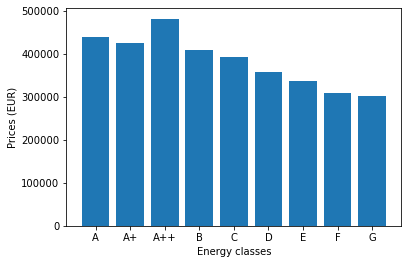

In [179]:
filtered_energy = immo[~immo['Energy class'].isin(['Not specified', 'F_C', 'A+_A++'])]

filtered_energy['Price'] = filtered_energy['Price'].astype(float)

energy_mean_price = filtered_energy.groupby('Energy class')['Price'].mean()

fig, ax = plt.subplots()

ax.bar(energy_mean_price.index, energy_mean_price.values)
ax.set_xlabel("Energy classes")

ax.set_ylabel("Prices (EUR)")

**Living area vs Price**

<AxesSubplot:xlabel='Surface of the plot', ylabel='Price'>

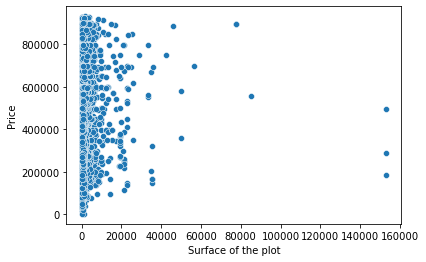

In [180]:
#surfaces = immo["Surface of the plot"]
#filtered_surf = immo[immo["Surface of the plot"].notna()]
# filtered_surf = immo[immo["Surface of the plot"] != 0]
# print(filtered_surf['Surface of the plot'])
# print(filtered_surf["Surface of the plot"].dtype)

# Drop rows with None values in the 'Surface of the plot' column
filtered_surfaces = immo.dropna(subset=['Surface of the plot'])

# Convert the column to numeric type if it's not already
filtered_surfaces['Surface of the plot'] = pd.to_numeric(filtered_surfaces['Surface of the plot'])

filtered_surfaces = filtered_surfaces[filtered_surfaces['Surface of the plot'] < 800000]

filtered_surfaces= filtered_surfaces[filtered_surfaces['Surface of the plot'] != None]

#print(filtered_surfaces["Surface of the plot"])

sns.scatterplot(data= filtered_surfaces, x = "Surface of the plot", y = "Price")



In [181]:
sample_immo = immo[1:20]

filtered_surfaces = sample_immo.dropna(subset=['Surface of the plot'])

sample_immo.head()

sample_immo.groupby(["Subtype_of_property"])
# filtered_surfaces['Surface of the plot'] = pd.to_numeric(filtered_surfaces['Surface of the plot'])

# filtered_surfaces = filtered_surfaces[filtered_surfaces['Surface of the plot'] < 800000]

# filtered_surfaces= filtered_surfaces[filtered_surfaces['Surface of the plot'] != None]

# print(filtered_surfaces["Surface of the plot"])

# sns.scatterplot(data= filtered_surfaces, x = "Surface of the plot", y = "Price")

**Price and bedrooms**

**Construction year and price**

In [182]:
sample = immo[0:10]
plt.figure(figsize=(20, 10))
sns.barplot(immo, x ="Construction year", y= "Price", errorbar=None)
plt.xticks(rotation=90)

# Get the current axis (matplotlib axis object)
ax = plt.gca()
# Format the y-axis labels as integers
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
#ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# Show the plot
plt.show()



C:\Users\lucav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input 'Price'

<Figure size 1440x720 with 0 Axes>

**Price and living area**

In [184]:
sample_immo = immo.groupby("Subtype_of_property")[0:100]

sample_immo_subset = sample_immo[sample_immo["Living area"]< 350]

fig, ax = plt.subplots()
ax.scatter(sample_immo_subset["Price"], sample_immo_subset["Living area"])
ax.set_xlabel("Price")
ax.set_ylabel("Living area (m2)")
plt.show()

TypeError: '<' not supported between instances of 'SeriesGroupBy' and 'int'

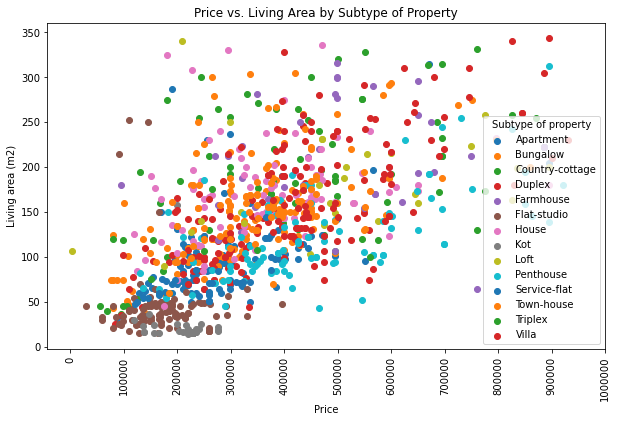

In [185]:
#Price is still not a float so I convert it here
#immo["Price"] = immo["Price"].astype(float)

# subtypes that I want to include
subtypes_to_include = ['House', 'Apartment', 'Villa', 'Kot', 'Bungalow', 'Country-cottage', 
                       'Duplex', 'Farmhouse', 'Flat-studio', 'Loft', 'Penthouse', 'Service-flat', 'Town-house', 'Triplex']

filtered_immo = immo[immo['Subtype_of_property'].isin(subtypes_to_include)]

# Group by subtype of property and take a sample of the first 100 rows for each group
sample_immo = filtered_immo.groupby("Subtype_of_property").head(100)

# Filter the sample to include only living areas less than 350
sample_immo_subset = sample_immo[sample_immo["Living area"] < 350]

#Filter prices above 1000000 
sample_immo_subset = sample_immo_subset[sample_immo_subset["Price"] < 1000000]

fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each unique subtype of property
for subtype, data in sample_immo_subset.groupby("Subtype_of_property"):
    # Scatter plot for the current subtype
    ax.scatter(data["Price"], data["Living area"], label=subtype)

x_labels = np.arange(0,1000001,100000)
ax.set_xlabel("Price")
ax.set_ylabel("Living area (m2)")
ax.legend(title="Subtype of property")
ax.set_xticks(x_labels)
ax.set_xticklabels(x_labels, rotation=90)
plt.title("Price vs. Living Area by Subtype of Property")
plt.show()


In [186]:
print(immo.Price.min())
print(immo.Price.max())

2500.0
932000.0


In [187]:
immo.Price.dtype

dtype('float64')

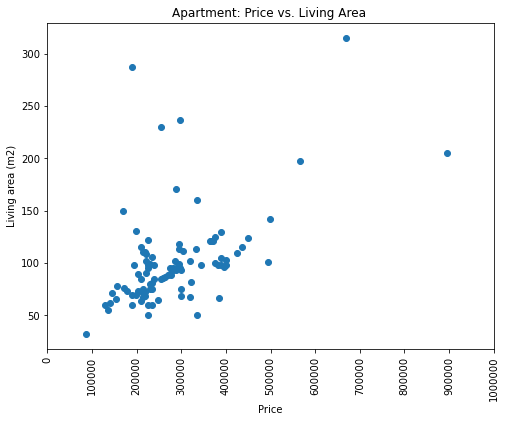

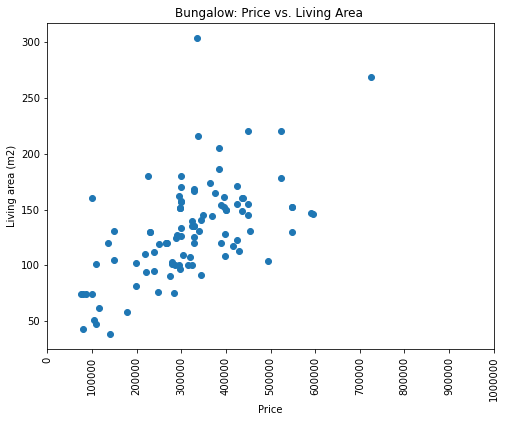

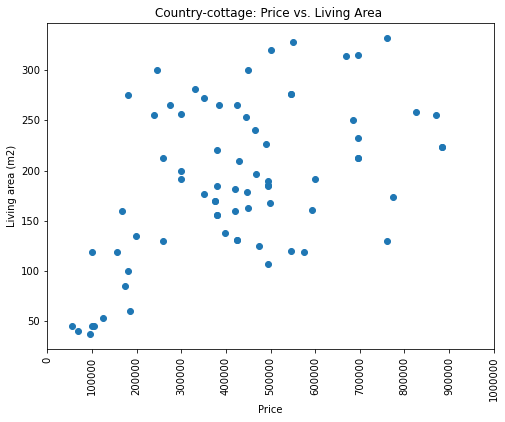

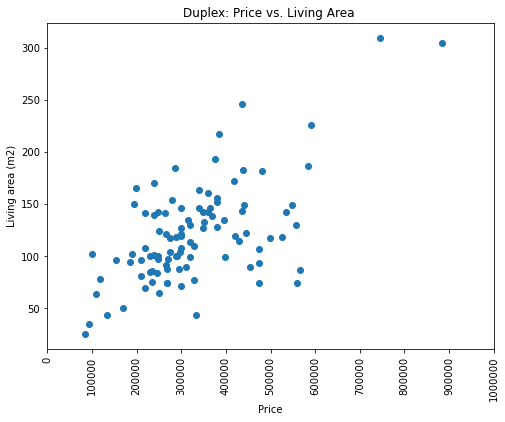

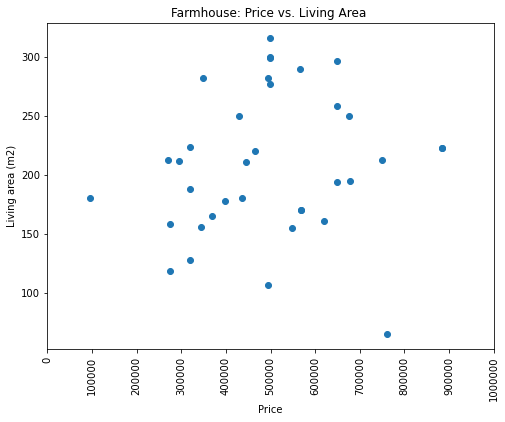

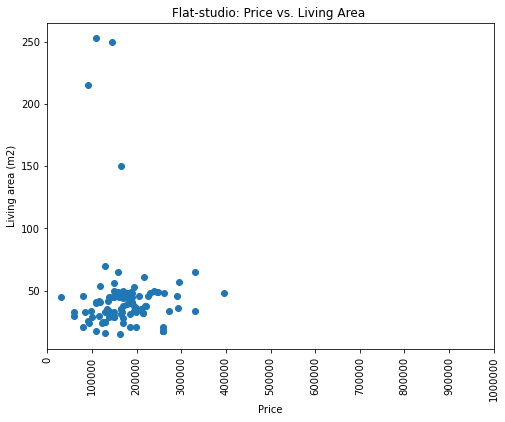

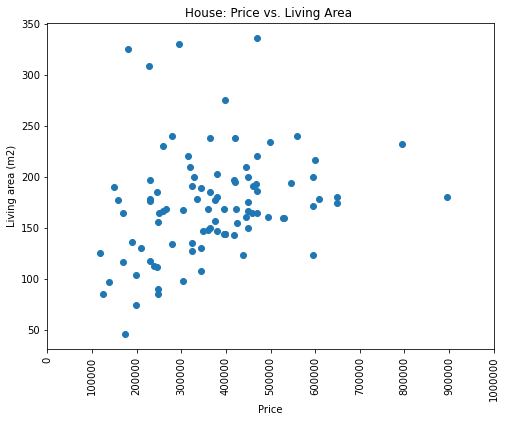

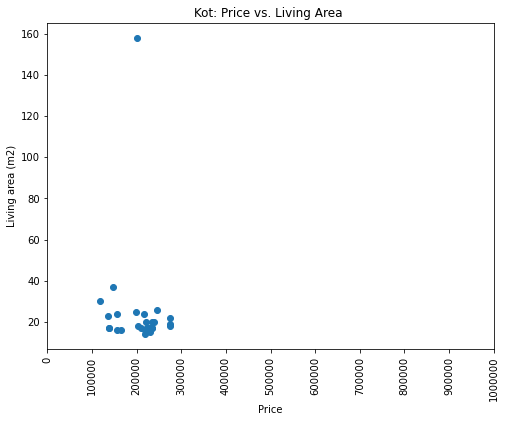

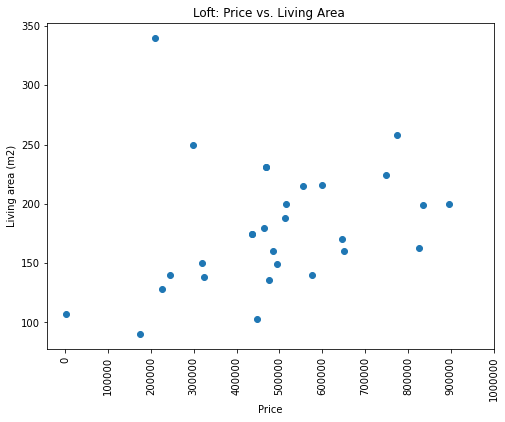

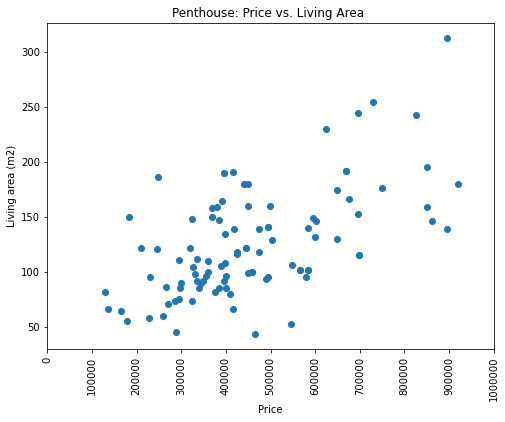

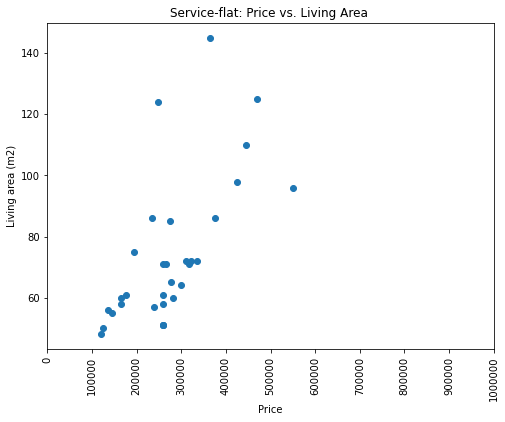

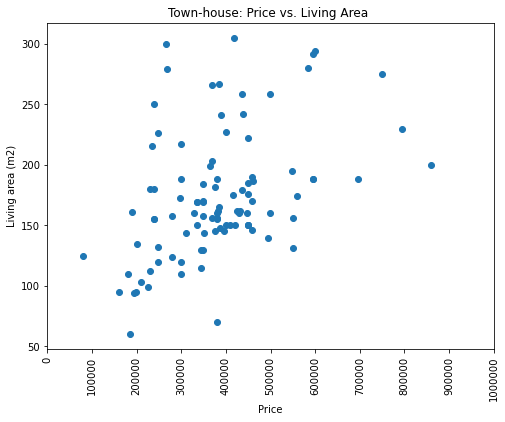

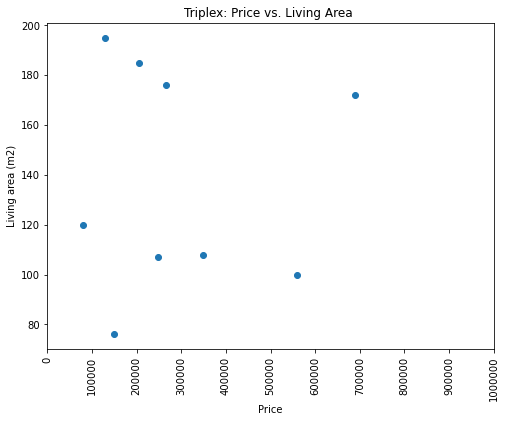

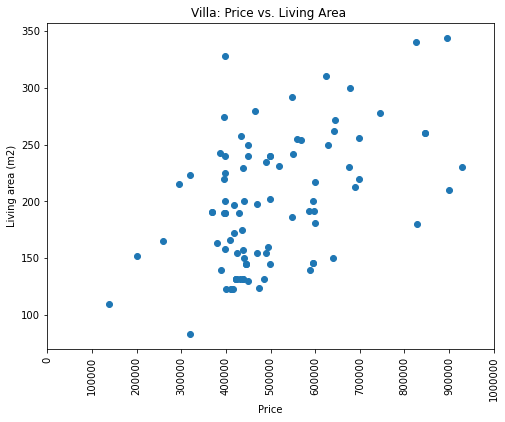

In [189]:
#immo["Price"] = immo["Price"].astype(float)

subtypes_to_include = ['House', 'Apartment', 'Villa', 'Kot', 'Bungalow', 'Country-cottage', 
                       'Duplex', 'Farmhouse', 'Flat-studio', 'Loft', 'Penthouse', 'Service-flat', 'Town-house', 'Triplex']

filtered_immo = immo[immo['Subtype_of_property'].isin(subtypes_to_include)]

sample_immo = filtered_immo.groupby("Subtype_of_property").head(100)

sample_immo_subset = sample_immo[sample_immo["Living area"] < 350]

sample_immo_subset = sample_immo_subset[sample_immo_subset["Price"] < 1000000]

# Iterate over each unique subtype of property
for subtype, data in sample_immo_subset.groupby("Subtype_of_property"):
    fig, ax = plt.subplots(figsize=(8,6))  
    ax.scatter(data["Price"], data["Living area"])
    x_labels = np.arange(0,1000001,100000)
    ax.set_xlabel("Price")
    ax.set_ylabel("Living area (m2)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(x_labels, rotation=90)
    ax.set_title(f"{subtype}: Price vs. Living Area ")
plt.show()


**Subtype of property**

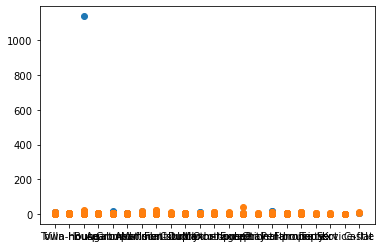

In [190]:
sample_immo = immo[immo["Subtype_of_property"] != "Mixed-use-building"]

fig, ax = plt.subplots()
ax.scatter(sample_immo["Subtype_of_property"], sample_immo["Toilets"])
ax.scatter(sample_immo["Subtype_of_property"], sample_immo["Bedrooms"])
#ax.legend()

plt.show()




Munincipalities 

In [144]:
immo.Postcode.dtype

dtype('float64')

In [191]:
immo_subset_mun = immo[["Municipality","Locality","Price","Living area","Energy class", "Subtype_of_property", "Construction year", ]]
immo_subset_mun.head()

,Municipality,Locality,Price,Living area,Energy class,Subtype_of_property,Construction year
1,Flanders,Ronse,259000.0,165.0,E,Villa,1959.0
6,Flanders,Zottegem,645000.0,272.0,E,Villa,1976.0
7,Wallonia,Seraing,329000.0,110.0,E,Mixed-use-building,1900.0
8,Flanders,Beersel,379000.0,160.0,F,Town-house,1979.0
9,Flanders,Tongeren,169000.0,165.0,F,House,1930.0


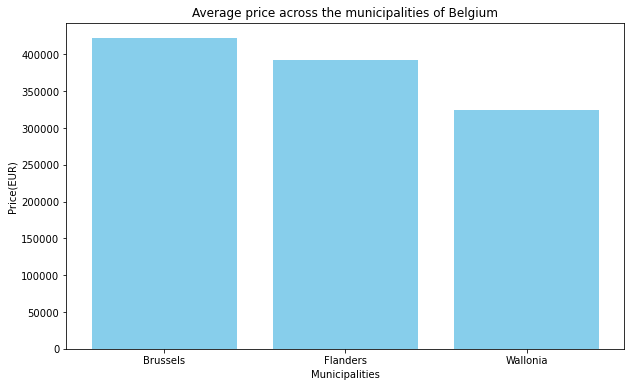

In [192]:
immo_mun_grouped=immo_subset_mun.groupby("Municipality").mean().reset_index()

immo_mun_grouped.head()

#immo_mun_sorted = immo_mun_grouped.sort_values(by="Price", ascending = False)

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(immo_mun_grouped["Municipality"], immo_mun_grouped["Price"], color = "skyblue")

ax.set_xlabel("Municipalities")
ax.set_ylabel("Price(EUR)")
ax.set_title("Average price across the municipalities of Belgium")
plt.show()


<ipython-input-193-096a741c06b5>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data["Locality"], rotation=45, ha='right')


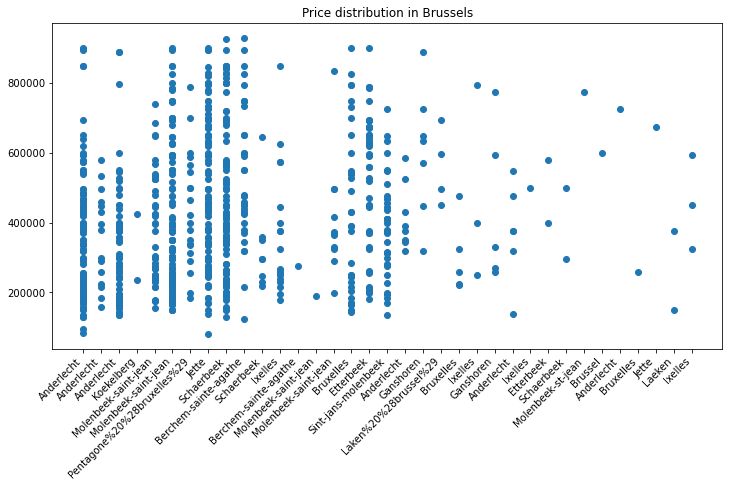

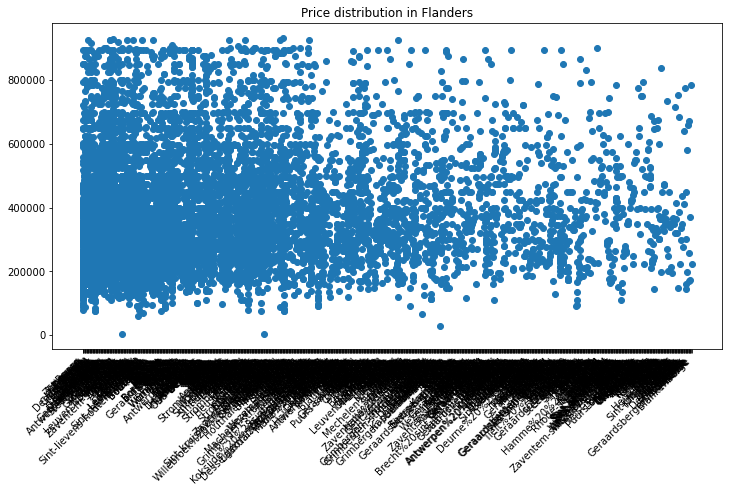

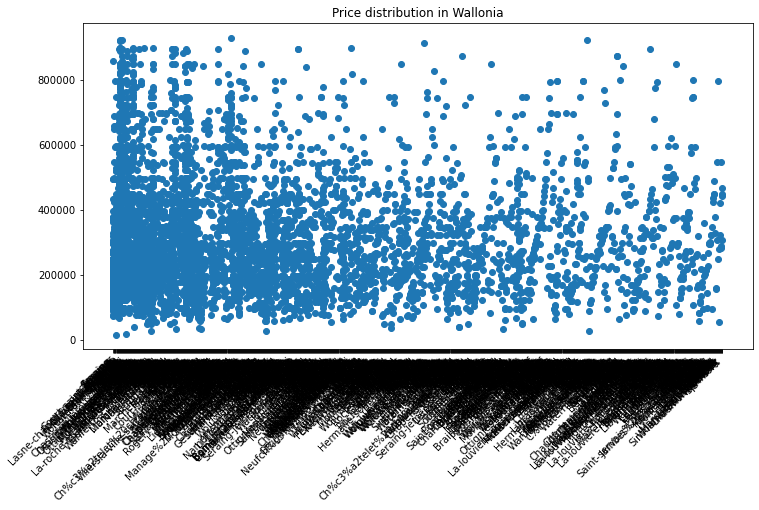

In [193]:
for municipality, data in immo_subset_mun.groupby("Municipality"):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.scatter(data["Locality"], data["Price"], label=municipality)
    ax.set_xticklabels(data["Locality"], rotation=45, ha='right') 
    ax.set_title (f"Price distribution in {municipality}")

plt.show()


In [167]:
test = immo[immo["Municipality"]=="Brussels"]
print((test["Locality"].value_counts()).sort_index)

<bound method Series.sort_index of Ixelles                        166
Bruxelles                      141
Schaerbeek                     119
Anderlecht                     118
Molenbeek-saint-jean            72
Saint-gilles                    60
Etterbeek                       60
Jette                           51
Brussels%20city                 39
Laeken                          32
Berchem-sainte-agathe           20
Ganshoren                       20
Koekelberg                      16
Brussel                         12
Sint-agatha-berchem             10
Brussels-city                    9
Brussels                         8
Sint-jans-molenbeek              8
Bruxelles%20%201                 6
Schaarbeek                       5
Sint-gillis                      5
Nord-est%20%28bruxelles%29       5
Elsene                           4
Pentagone-bruxelles              3
Laeken%20%28bru.%29              2
Laken                            2
Laeken-bru                       2
Pentagone%20%28bruxe

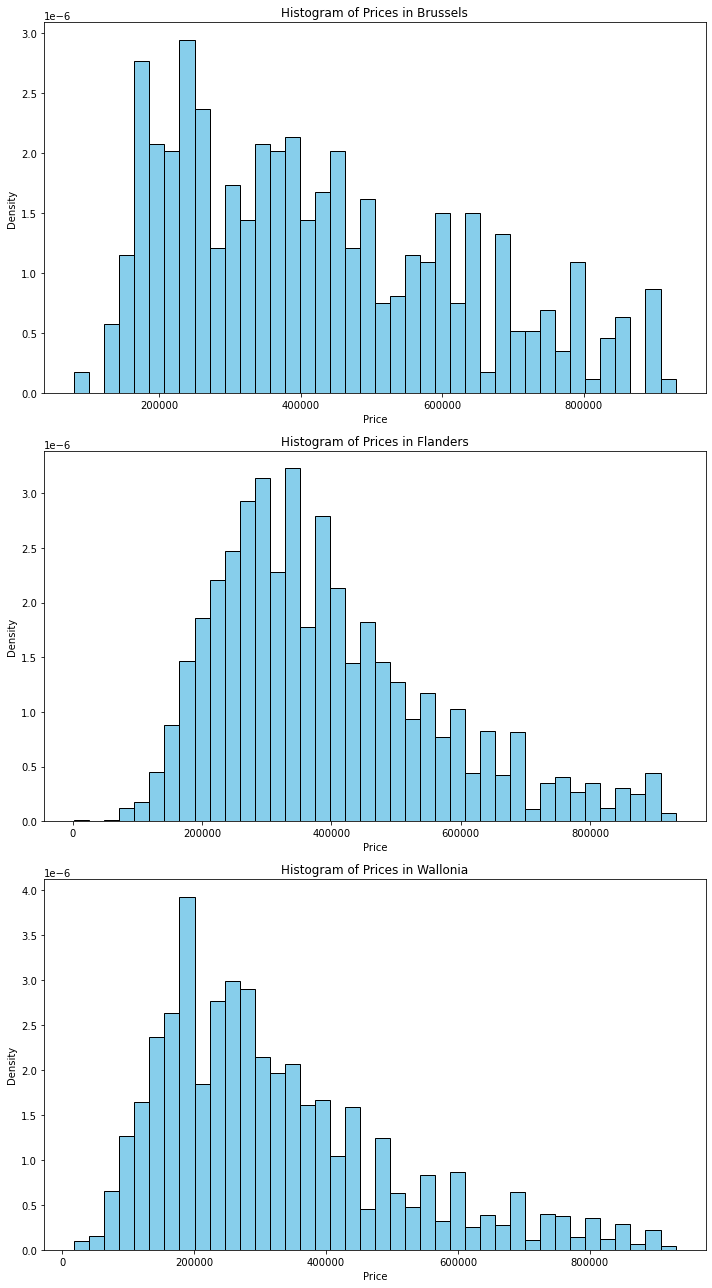

In [194]:
#settng a price limit

#immo = immo[immo["Price"]< price_range] 

fig, axes = plt.subplots(nrows=3, figsize=(10, 6 * 3))

for ax, (municipality, data) in zip(axes, immo_subset_mun.groupby("Municipality")):
    ax.hist(data["Price"], bins=40, color='skyblue', edgecolor='black', density = True)
    ax.set_title(f'Histogram of Prices in {municipality}')
    ax.set_xlabel('Price')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()